We can trigger based on 2 criteria:
1. NPE per SiPM module (Slice)
1. Multiplicity of SiPM modules active (w.r.t. previous point)

In [12]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Ar39", "SnapshotAr39")
fileinprefix = "SnapshotAr39*.csv"

df_ar39 = load_dataframe_from_files(dirin, fileinprefix, max_files=30)
df_ar39 = df_ar39[df_ar39.pedetected>0]
df_ar39 = df_ar39[df_ar39.columns[:-1]]

[Info] Loading 100 files wt prefix:
SnapshotAr39*.csv
.............................


In [4]:
# Compute the Nr of Active Slices (NPE>1)
nactiveslices_ar39 = df_ar39.iloc[:, 3:].apply(lambda row: np.nonzero(row.to_numpy())[0].shape[0], axis=1)

In [5]:
nactiveslices_ar39.describe()

count    1.892861e+06
mean     2.917529e+00
std      2.314999e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      2.400000e+01
dtype: float64

In [6]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Muons", "SnapshotMuons")
fileinprefix = "SnapshotMuons*.csv"

df_mu = load_dataframe_from_files(dirin, fileinprefix, max_files=100)
df_mu = df_mu[df_mu.pedetected>0]
df_mu = df_mu[df_mu.columns[:-1]]

[Info] Loading 100 files wt prefix:
SnapshotMuons*.csv
...................................................................................................


In [36]:
df_mu["nactiveslices"] = df_mu.iloc[:, 3:].apply(lambda row: np.nonzero(row.to_numpy())[0].shape[0], axis=1)
df_ar39["nactiveslices"] = df_ar39.iloc[:, 3:].apply(lambda row: np.nonzero(row.to_numpy())[0].shape[0], axis=1)

In [39]:
df_ar39.nactiveslices.describe()

count    1.892861e+06
mean     2.917529e+00
std      2.314999e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      2.400000e+01
Name: nactiveslices, dtype: float64

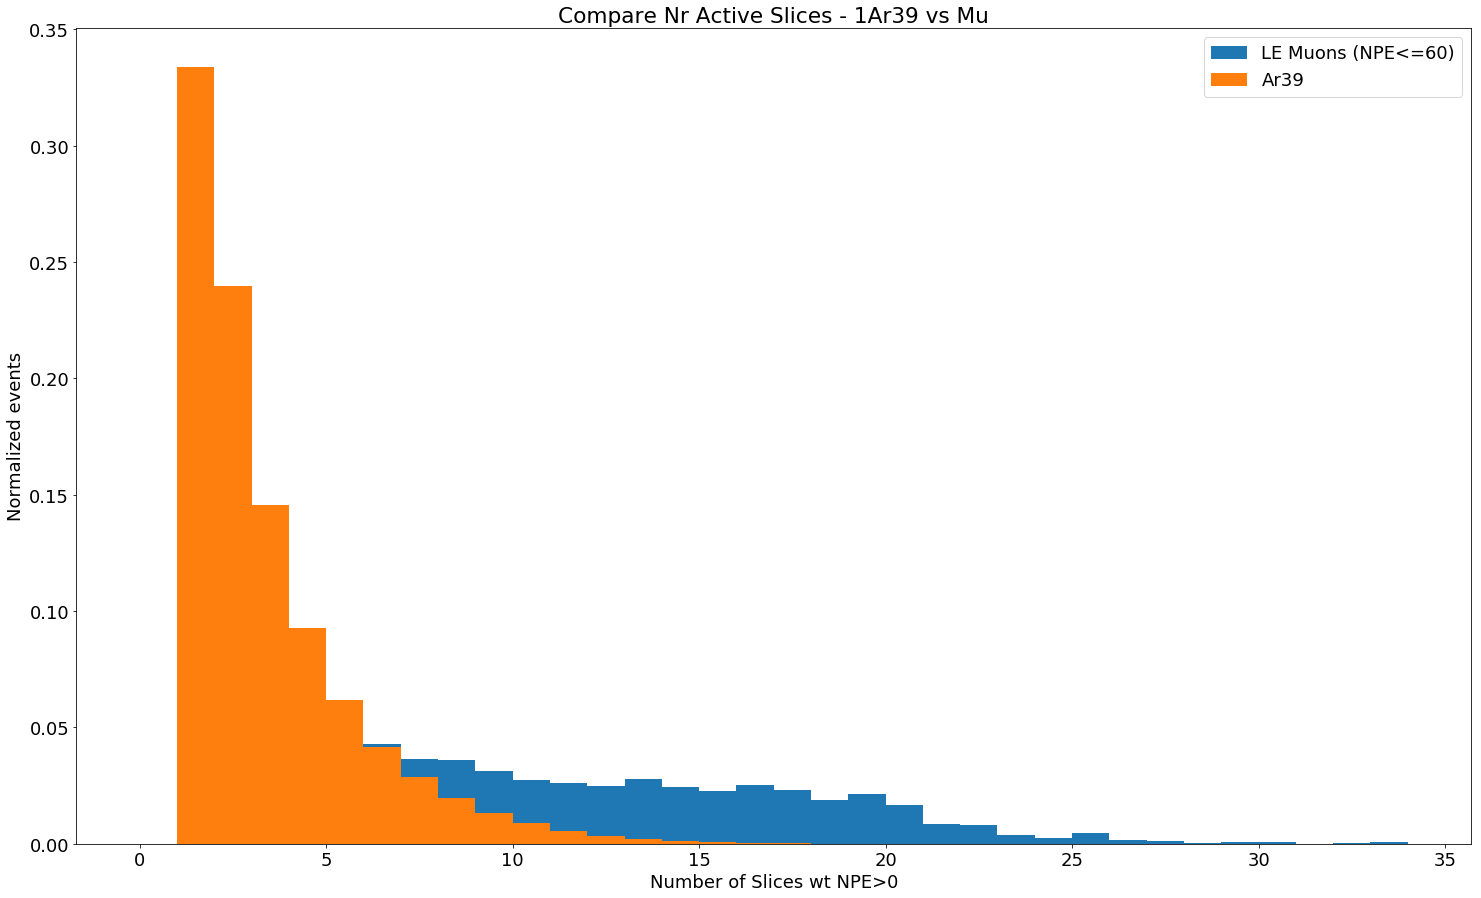

In [11]:
plt.title("Compare Nr Active Slices - 1Ar39 vs Mu")
bins = np.linspace(0, 34, 35)
plt.hist(nactiveslices_lemu, bins=bins, label="LE Muons (NPE<=60)", density=True)
plt.hist(nactiveslices_ar39, bins=bins, label="Ar39", density=True)
plt.xlabel("Number of Slices wt NPE>0")
plt.ylabel("Normalized events")
plt.legend()
plt.show()

# Discuss with Diego
Given the measured activity of Ar39 in LAr, we compute the rate of 1, 2, 3, ... (detected) decays over the same time window `T=10us`. 

The probability of a single decay (normalized over the probability of >=1 decays) is dominant `98.83%`. The pileup of 2, 3, ... decays is only `1.17%`.

To overestimate the rate, we ignore the effect of trigger on pileups and assume that we cannot reduce the `1.17%` (*simplification, not true*). 
Then, the number of False Positive (False Alarm) directly affect the expected trigger rate:

(`FPR * 0.9883 + 0.0117) * AR39_RATE`

In [14]:
# Overestimation of the Expected Trigger Rate
import math

AR39_RATE = 2353    # 3666 decay/s -> 64.17% of detection efficiency
for FPR in [0.01, 0.03, 0.05, 0.10, 1]:
    print("FPR: {} =>\t{} Hz".format(FPR, math.ceil((FPR * 0.9883 + 0.0117) * AR39_RATE)))

FPR: 0.01 =>	51 Hz
FPR: 0.03 =>	98 Hz
FPR: 0.05 =>	144 Hz
FPR: 0.1 =>	261 Hz
FPR: 1 =>	2353 Hz


Nr Active Slices: 1 	=>	FPR: 1.000000	=>	Trigger Rate: 2353 Hz
Nr Active Slices: 2 	=>	FPR: 0.666256	=>	Trigger Rate: 1577 Hz
Nr Active Slices: 3 	=>	FPR: 0.426479	=>	Trigger Rate: 1020 Hz
Nr Active Slices: 4 	=>	FPR: 0.280826	=>	Trigger Rate: 681 Hz
Nr Active Slices: 8 	=>	FPR: 0.055752	=>	Trigger Rate: 158 Hz
Nr Active Slices: 16 	=>	FPR: 0.000580	=>	Trigger Rate: 29 Hz
Nr Active Slices: 32 	=>	FPR: 0.000000	=>	Trigger Rate: 28 Hz


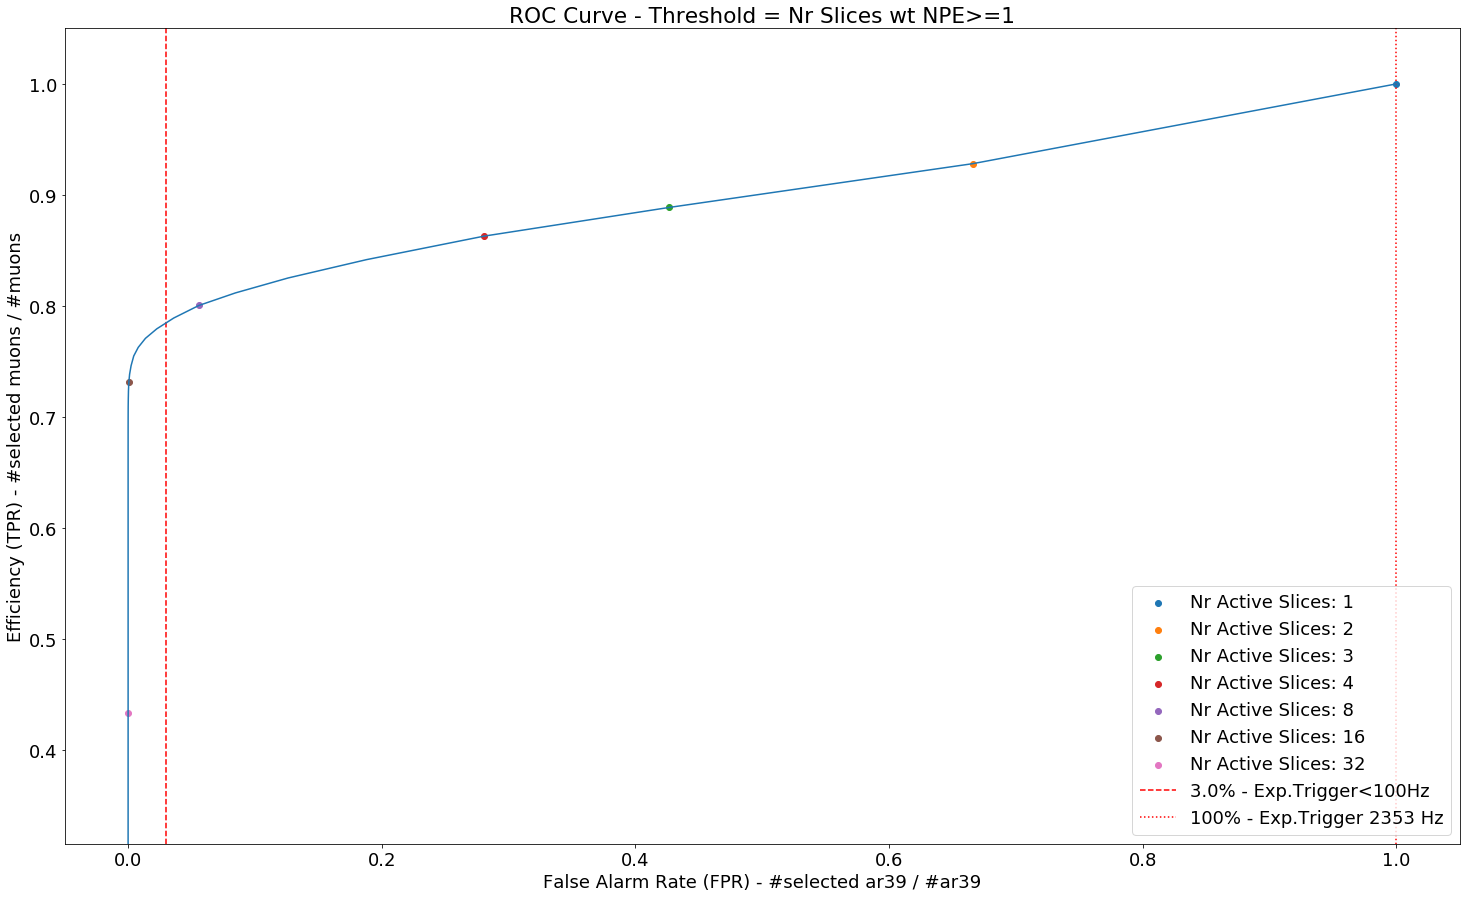

In [40]:
thresholds = []
tprs = []
fprs = []
for threshold in range(1, 40):
    tp = len(nactiveslices_mu[nactiveslices_mu>=threshold])
    fn = len(nactiveslices_mu[nactiveslices_mu<threshold])
    tn = len(nactiveslices_ar39[nactiveslices_ar39<threshold])
    fp = len(nactiveslices_ar39[nactiveslices_ar39>=threshold])
    tpr = tp / len(nactiveslices_mu)
    fpr = fp / len(nactiveslices_ar39)
    thresholds.append(threshold)
    tprs.append(tpr)
    fprs.append(fpr)
plt.plot(fprs, tprs)
plt.ylabel("Efficiency (TPR) - #selected muons / #muons")
plt.xlabel("False Alarm Rate (FPR) - #selected ar39 / #ar39")
for mark_threshold in [1, 2, 3, 4, 8, 16, 32]:
    id_t = thresholds.index(mark_threshold)
    plt.scatter(fprs[id_t], tprs[id_t], label="Nr Active Slices: {}".format(mark_threshold))
    exp_trigger_rate = math.ceil((fprs[id_t] * 0.9883 + 0.0117) * AR39_RATE)
    print("Nr Active Slices: {} \t=>\tFPR: {:2f}\t=>\tTrigger Rate: {} Hz".format(mark_threshold, fprs[id_t], exp_trigger_rate))
plt.vlines(0.03, ymin=0, ymax=1.05, label="{}% - Exp.Trigger<100Hz".format(0.03*100), color='r', linestyles='dashed')
plt.vlines(1, ymin=0, ymax=1.05, label="{}% - Exp.Trigger 2353 Hz".format(1*100), color='r', linestyles='dotted')
plt.legend(loc="lower right")
plt.ylim(min(tprs), 1.05)
plt.xlim(-0.05, 1.05)
plt.title("ROC Curve - Threshold = Nr Slices wt NPE>=1")
plt.show()

## Question:
1. Reasonable trigger rate? 100 Hz? <100 Hz?
1. If ~100Hz is reasonable, try ML on instances wt >=8 
    